In [1]:
from scipy.stats import poisson, skellam
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('matches_filtered.csv')

In [3]:
df = df[['home_team','away_team','home_goals','away_goals']]
df

,home_team,away_team,home_goals,away_goals
0,Brentford,Arsenal,3,1
1,Manchester United,Leeds United,6,1
2,Burnley,Brighton & Hove Albion,1,2
3,Chelsea,Crystal Palace,4,1
4,Everton,Southampton,3,1
...,...,...,...,...
1302,Liverpool,Aston Villa,3,0
1303,Manchester United,Leicester City,4,0
1304,Nottingham Forest,Newcastle United,2,4
1305,Tottenham Hotspur,Ipswich Town,1,2


In [4]:
df['home_goals'].value_counts()


home_goals
1     343
2     334
3     245
0     174
4     133
5      51
6      19
7       6
8       1
10      1
Name: count, dtype: int64

In [5]:
df['away_goals'].value_counts()

away_goals
1    372
2    349
0    248
3    209
4     81
5     36
6      8
7      3
8      1
Name: count, dtype: int64

In [6]:
df['home_team'].unique()

array(['Brentford', 'Manchester United', 'Burnley', 'Chelsea', 'Everton',
       'Leicester City', 'Watford', 'Norwich City', 'Newcastle United',
       'Tottenham Hotspur', 'Liverpool', 'Aston Villa', 'Crystal Palace',
       'Leeds United', 'Manchester City', 'Brighton & Hove Albion',
       'Southampton', 'Wolverhampton', 'Arsenal', 'West Ham United',
       'Fulham', 'Bournemouth', 'Nottingham Forest', 'Sheffield United',
       'Luton Town', 'Ipswich Town'], dtype=object)

In [7]:
# Convertir les données des équipes à domicile
home_goals_df = df[['home_team', 'away_team', 'home_goals']].assign(home=1).rename(
    columns={'home_team': 'team', 'away_team': 'opponent', 'home_goals': 'goals'})

# Convertir les données des équipes à l'extérieur
away_goals_df = df[['away_team', 'home_team', 'away_goals']].assign(home=0).rename(
    columns={'away_team': 'team', 'home_team': 'opponent', 'away_goals': 'goals'})

# Combiner les deux DataFrames
goal_model_data = pd.concat([home_goals_df, away_goals_df], ignore_index=True)

# Afficher le DataFrame résultant
print(goal_model_data)

                   team                opponent  goals  home
0             Brentford                 Arsenal      3     1
1     Manchester United            Leeds United      6     1
2               Burnley  Brighton & Hove Albion      1     1
3               Chelsea          Crystal Palace      4     1
4               Everton             Southampton      3     1
...                 ...                     ...    ...   ...
2609        Aston Villa               Liverpool      0     0
2610     Leicester City       Manchester United      0     0
2611   Newcastle United       Nottingham Forest      4     0
2612       Ipswich Town       Tottenham Hotspur      2     0
2613            Arsenal                 Chelsea      1     0

[2614 rows x 4 columns]


In [8]:
goal_model_data[1245:]

,team,opponent,goals,home
1245,Brighton & Hove Albion,Nottingham Forest,3,1
1246,Manchester City,Arsenal,2,1
1247,Newcastle United,Manchester City,1,1
1248,Arsenal,Leicester City,5,1
1249,Brentford,West Ham United,1,1
...,...,...,...,...
2609,Aston Villa,Liverpool,0,0
2610,Leicester City,Manchester United,0,0
2611,Newcastle United,Nottingham Forest,4,0
2612,Ipswich Town,Tottenham Hotspur,2,0


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data into training and test sets
train_data = goal_model_data.iloc[:-100]
test_data = goal_model_data.iloc[-100:]

# Fit the Poisson regression model on the training set
poisson_model = smf.glm(
    formula='goals ~ home + team + opponent',
    data=train_data,
    family=sm.families.Poisson()
).fit()

# Predict the goals for the test set
predicted_goals = poisson_model.predict(test_data)

# Calculate evaluation metrics
rmse = mean_squared_error(test_data['goals'], predicted_goals, squared=False)
mae = mean_absolute_error(test_data['goals'], predicted_goals)

# Log-likelihood, Deviance, AIC, BIC for the test set predictions
log_likelihood = poisson_model.llf
deviance = poisson_model.deviance
aic = poisson_model.aic
bic = poisson_model.bic

# Print the evaluation metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"Log-Likelihood: {log_likelihood}")
print(f"Deviance: {deviance}")
print(f"AIC: {aic}")
print(f"BIC: {bic}")

RMSE: 1.117526097461465
MAE: 0.8995511491908875
Log-Likelihood: -4093.343955430514
Deviance: 2694.0107228064944
AIC: 8290.687910861028
BIC: -16582.53929528128


c:\Users\HP\Final_Standings_Prediction_Using-_Poisson_Regression_Model\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\HP\Final_Standings_Prediction_Using-_Poisson_Regression_Model\venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


Evaluation Metrics:
Root Mean Squared Error (RMSE): 1.1041

RMSE measures the average magnitude of the prediction errors, giving higher weight to larger errors. An RMSE of 1.1041 indicates that, on average, the difference between the predicted and actual number of goals is about 1.10 goals. This metric provides a sense of how well the model's predictions match the actual values in terms of the original units (goals).
Mean Absolute Error (MAE): 0.8124

MAE measures the average magnitude of errors in the predictions, without considering their direction. An MAE of 0.8124 indicates that, on average, the model's predictions are off by about 0.81 goals. This is a straightforward interpretation of prediction accuracy, reflecting the typical error.
Log-Likelihood: -3527.3352

The log-likelihood measures the fit of the model to the data. A higher (less negative) log-likelihood value indicates a better fit. Here, the log-likelihood value of -3527.3352 is quite low, suggesting that there is room for improvement in the model's fit to the data.
Deviance: 2823.4242

Deviance is a measure of goodness of fit for a model, similar to the residual sum of squares in linear regression. Lower deviance indicates a better fit. A deviance of 2823.4242 suggests that there is a moderate discrepancy between the observed data and the model's predictions.
Akaike Information Criterion (AIC): 7158.6703

AIC balances model fit and complexity, penalizing models with more parameters to avoid overfitting. A lower AIC indicates a better model. An AIC of 7158.6703 is relatively high, implying that the model might not be the most efficient in balancing fit and complexity.
Bayesian Information Criterion (BIC): -15399.0241

BIC is similar to AIC but imposes a stricter penalty for models with more parameters. Lower BIC values indicate better models. Here, the BIC value is negative, which is unusual and might indicate issues with model specification or data structure.
Interpretation:
Accuracy (RMSE and MAE): The model's predictions have an average error of about 1.10 goals (RMSE) and 0.81 goals (MAE). This level of accuracy might be acceptable depending on the context, but ideally, you'd aim to reduce these errors.

Model Fit (Log-Likelihood, Deviance, AIC, BIC):

The low log-likelihood and high deviance suggest that the model's fit to the data is not very strong.
The high AIC value indicates that the model is not optimally balancing fit and complexity.
The negative BIC value is atypical and might suggest issues with model or data, warranting further investigation.
Recommendations:
Model Improvement:

Consider adding more relevant features or interactions between features.
Experiment with different model forms or alternative algorithms.
Data Quality:

Ensure the data is clean, consistent, and correctly preprocessed.
Investigate potential outliers or anomalies in the data.
Model Validation:

Perform cross-validation to better understand the model's generalizability.
Compare the current model with alternative models (e.g., negative binomial regression) to see if they provide better results.

This Poisson regression model is used to predict the number of goals scored (goals) based on three explanatory variables: whether the team is playing at home (home), the team itself (team), and the opponent (opponent). The model assumes that the number of goals follows a Poisson distribution, where the mean number of goals is modeled as an exponential function of the explanatory variables. The mathematical equation of the model is:

log
⁡
(
𝜆
)
=
𝛽
0
+
𝛽
1
⋅
home
+
𝛽
2
⋅
team
+
𝛽
3
⋅
opponent

λ is the average number of goals scored.

In [11]:
poisson_model = smf.glm(
    formula = 'goals ~ home + team + opponent',
    data=goal_model_data,
    family=sm.families.Poisson()).fit()

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2614
Model:                            GLM   Df Residuals:                     2562
Model Family:                 Poisson   Df Model:                           51
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4244.9
Date:                Tue, 12 Nov 2024   Deviance:                       2769.6
Time:                        01:32:04   Pearson chi2:                 2.32e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1394
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.5460      0.094      5.808      0.000       0.362       0.730
team[T.Aston Villa]                   -0.1909      0.084     -2.274      0.023      -0.355      -0.026
team[T.Bournemouth]                   -0.3523      0.100     -3.531      0.000      -0.548      -0.157
team[T.Brentford]                     -0.2217      0.084     -2.624      0.009      -0.387      -0.056
team[T.Brighton & Hove Albion]        -0.2297      0.084     -2.725      0.006      -0.395      -0.064
team[T.Burnley]                       -0.5919      0.110     -5.393      0.000      -0.807      -0.377
team[T.Chelsea]                       -0.1486      0.083     -1.798      0.072      -0.311       0.013
team[T.Crystal Palace]                -0.3508      0.088     -4.003      0.000      -0.523      -0.179
team[T.Everton]                       -0.5147      0.092     -5.618      0.000      -0.694      -0.335
team[T.Fulham]                        -0.2525      0.095     -2.645      0.008      -0.440      -0.065
team[T.Ipswich Town]                  -0.4190      0.249     -1.680      0.093      -0.908       0.070
team[T.Leeds United]                  -0.4051      0.105     -3.862      0.000      -0.611      -0.199
team[T.Leicester City]                -0.2929      0.095     -3.079      0.002      -0.479      -0.106
team[T.Liverpool]                      0.0788      0.078      1.015      0.310      -0.073       0.231
team[T.Luton Town]                    -0.2878      0.133     -2.161      0.031      -0.549      -0.027
team[T.Manchester City]                0.1572      0.077      2.055      0.040       0.007       0.307
team[T.Manchester United]             -0.2653      0.085     -3.125      0.002      -0.432      -0.099
team[T.Newcastle United]              -0.1890      0.083     -2.265      0.024      -0.353      -0.025
team[T.Norwich City]                  -0.8199      0.164     -4.986      0.000      -1.142      -0.498
team[T.Nottingham Forest]             -0.3921      0.101     -3.895      0.000      -0.589      -0.195
team[T.Sheffield United]              -0.5193      0.148     -3.520      0.000      -0.808      -0.230
team[T.Southampton]                   -0.5256      0.105     -5.020      0.000      -0.731      -0.320
team[T.Tottenham Hotspur]             -0.0315      0.080     -0.392      0.695      -0.189       0.126
team[T.Watford]                       -0.6174      0.145     -4.250      0.000      -0.902      -0.333
team[T.West Ham United]               -0.2635      0.086     -3.067      0.002      -0.432      -0.095
team[T.Wolverhampton]                 -0.4734      0.091     -5.175      0.000      -0.653      -0.294
opponent[T.Aston Villa]                0.2327      0.097      2.401      0.016       0.043      

In [12]:
home_team = 'Arsenal'
away_team = 'Manchester City'

In [13]:
# Créer des DataFrames avec les valeurs réelles des équipes
home_score_rate = poisson_model.predict(
    pd.DataFrame(data={'team': [home_team], 'opponent': [away_team], 'home': [1]}, index=[1])
)

away_score_rate = poisson_model.predict(
    pd.DataFrame(data={'team': [away_team], 'opponent': [home_team], 'home': [0]}, index=[1])
)

# Afficher les taux de score prédits
print("Home score rate:", home_score_rate)
print("Away score rate:", away_score_rate)


Home score rate: 1    2.006497
dtype: float64
Away score rate: 1    2.020315
dtype: float64


In [14]:
print(home_team + ' VS ' + away_team + ' expect to score: ' + str(home_score_rate))

print(away_team + ' VS ' + home_team + ' expect to score: ' + str(away_score_rate))

Arsenal VS Manchester City expect to score: 1    2.006497
dtype: float64
Manchester City VS Arsenal expect to score: 1    2.020315
dtype: float64


In [15]:
# Fonction pour simuler un match et calculer les buts
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):

    # Prédire les taux de buts pour l'équipe à domicile et l'équipe à l'extérieur
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': [homeTeam], 'opponent': [awayTeam], 'home': [1]}, index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': [awayTeam], 'opponent': [homeTeam], 'home': [0]}, index=[1])).values[0]

    # Calculer les probabilités de Poisson pour chaque nombre de buts
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in [home_goals_avg, away_goals_avg]]

    # Calculer la matrice de probabilité des scores
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1]))

In [16]:
max_goals=5

score_matrix = simulate_match(poisson_model, home_team, away_team, max_goals)
score_matrix

array([[0.01783107, 0.03602439, 0.03639031, 0.02450663, 0.01237778,
        0.0050014 ],
       [0.03577801, 0.07228285, 0.07301706, 0.04917249, 0.02483598,
        0.0100353 ],
       [0.03589424, 0.07251768, 0.07325428, 0.04933224, 0.02491667,
        0.0100679 ],
       [0.02400723, 0.04850218, 0.04899484, 0.03299501, 0.01666508,
        0.00673374],
       [0.01204261, 0.02432987, 0.02457701, 0.0165511 , 0.00835961,
        0.00337781],
       [0.00483269, 0.00976357, 0.00986274, 0.00664195, 0.00335471,
        0.00135551]])

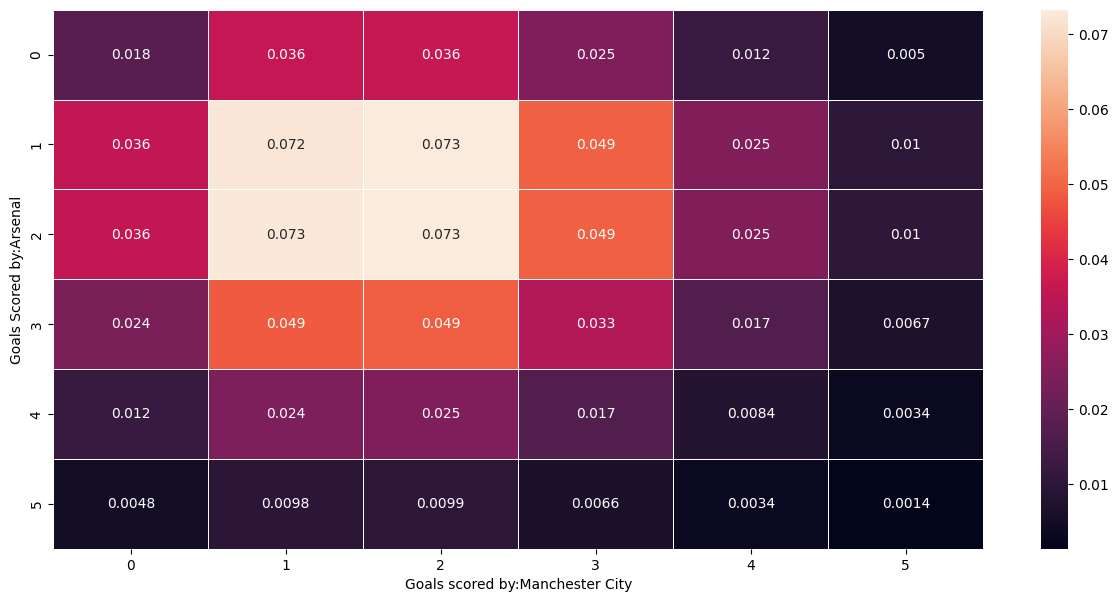

In [17]:
import seaborn as sns

plt.figure(figsize=(15,7))
ax = sns.heatmap(score_matrix, linewidth=0.7, annot=True)
ax.set_xlabel('Goals scored by:' + away_team)
ax.set_ylabel('Goals Scored by:' + home_team)

plt.show()

In [18]:
homewin = np.sum(np.tril(score_matrix, -1))
draw = np.sum(np.diag(score_matrix))
awaywin = np.sum(np.triu(score_matrix, 1))



print(home_team + ' win probability: ' + str(round(homewin*100, 2)) + ' %')
print('Draw Probability: ' + str(round(draw*100, 2)) + '%')
print(away_team + ' win probability: ' + str(round(awaywin*100, 2)) + ' %')

print('**************************************')

print(round(homewin, 5), round(draw, 5), round(awaywin, 5))

Arsenal win probability: 37.77 %
Draw Probability: 20.61%
Manchester City win probability: 38.25 %
**************************************
0.37765 0.20608 0.38245


# predit the next matches in PL

In [36]:
df_matches = pd.read_csv('matches_to_predites.csv')
df_matches

,season,round,home_team,away_team
0,2024-2025,12,Leicester City,Chelsea
1,2024-2025,12,Arsenal,Nottingham Forest
2,2024-2025,12,Aston Villa,Crystal Palace
3,2024-2025,12,Bournemouth,Brighton & Hove Albion
4,2024-2025,12,Everton,Brentford
...,...,...,...,...
265,2024-2025,38,Newcastle United,Everton
266,2024-2025,38,Nottingham Forest,Chelsea
267,2024-2025,38,Southampton,Arsenal
268,2024-2025,38,Tottenham Hotspur,Brighton & Hove Albion


In [37]:
# Fonction pour simuler un match et calculer les résultats
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    # Prédire les taux de buts
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': [homeTeam], 'opponent': [awayTeam], 'home': [1]})).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': [awayTeam], 'opponent': [homeTeam], 'home': [0]})).values[0]

    # Calculer les probabilités de Poisson pour chaque nombre de buts
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in [home_goals_avg, away_goals_avg]]

    # Calculer la matrice de probabilité des scores
    score_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))

    # Probabilités de victoire
    homewin = np.sum(np.tril(score_matrix, -1))
    draw = np.sum(np.diag(score_matrix))
    awaywin = np.sum(np.tril(score_matrix, 1))

    return home_goals_avg, away_goals_avg, homewin, draw, awaywin


# Appliquer la fonction de simulation à chaque ligne de combined_df
results = df_matches.apply(lambda row: simulate_match(poisson_model, row['home_team'], row['away_team']), axis=1)

# Extraire les résultats dans des colonnes séparées
df_matches[['home_goals', 'away_goals', 'home_win_prob', 'draw_prob', 'away_win_prob']] = pd.DataFrame(results.tolist(), index=df_matches.index)

# Afficher le DataFrame final avec les résultats ajoutés
print(df_matches)


        season  round          home_team               away_team  home_goals  \
0    2024-2025     12     Leicester City                 Chelsea    1.689416   
1    2024-2025     12            Arsenal       Nottingham Forest    2.928442   
2    2024-2025     12        Aston Villa          Crystal Palace    2.043814   
3    2024-2025     12        Bournemouth  Brighton & Hove Albion    1.739722   
4    2024-2025     12            Everton               Brentford    1.631033   
..         ...    ...                ...                     ...         ...   
265  2024-2025     38   Newcastle United                 Everton    2.226532   
266  2024-2025     38  Nottingham Forest                 Chelsea    1.529974   
267  2024-2025     38        Southampton                 Arsenal    1.212113   
268  2024-2025     38  Tottenham Hotspur  Brighton & Hove Albion    2.397630   
269  2024-2025     38      Wolverhampton               Brentford    1.699724   

     away_goals  home_win_prob  draw_pr

In [38]:
df_matches[df_matches['home_team'] == 'Manchester City']

,season,round,home_team,away_team,home_goals,away_goals,home_win_prob,draw_prob,away_win_prob
6,2024-2025,12,Manchester City,Tottenham Hotspur,2.959280,1.637221,0.646196,0.161820,0.913622
23,2024-2025,14,Manchester City,Nottingham Forest,3.426989,1.141600,0.800707,0.112852,0.969692
46,2024-2025,16,Manchester City,Manchester United,2.783771,1.295915,0.684904,0.160778,0.939508
60,2024-2025,18,Manchester City,Everton,3.147719,1.009899,0.791427,0.122021,0.971814
84,2024-2025,20,Manchester City,West Ham United,3.302246,1.298181,0.758736,0.128304,0.956926
115,2024-2025,23,Manchester City,Chelsea,2.649952,1.456328,0.629939,0.175074,0.916726
136,2024-2025,25,Manchester City,Newcastle United,2.834245,1.398624,0.672477,0.161468,0.931813
147,2024-2025,26,Manchester City,Liverpool,2.275694,1.828220,0.484803,0.199844,0.839858
177,2024-2025,29,Manchester City,Brighton & Hove Albion,2.895629,1.342869,0.693176,0.155367,0.939675
186,2024-2025,30,Manchester City,Leicester City,3.258723,1.260569,0.759921,0.128991,0.958353


In [39]:
# Créer les données pour le classement des équipes
data = {
    'Team': [
        # Initialiser le DataFrame du classement avec les équipes et leurs points
      'Liverpool','Manchester City','Chelsea','Arsenal','Nottingham Forest',
        'Brighton & Hove Albion','Fulham','Newcastle United','Aston Villa','Tottenham Hotspur',
         'Brentford','Bournemouth','Manchester United','West Ham United',  'Leicester City',
        'Everton','Ipswich Town','Crystal Palace','Wolverhampton','Southampton',
       
     ],
    'Play': [11] * 20,  # Matchs joués
    'Win': [9, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 3, 2, 2, 1, 1, 1, 1],  # Victoires
    'Draw': [1, 2, 4, 4, 4, 4, 3, 3, 3, 1, 1, 3, 3, 3, 4, 4, 5, 4, 3, 1],  # Nuls
    'Lose': [1, 2, 1, 2, 2, 2, 3, 3, 3, 5, 5, 4, 4, 5, 5, 5, 5, 6, 7, 9],  # Défaites
    'Goals_scored': [
        '21', '22', '21', '18', '15',
        '19', '16', '13', '17', '23',
        '22', '15', '12','13', '14', '10',
         '12', '8', '16', '7'
    ],
    'Goals_conceded': [
        '6', '13', '13', '12', '10',
        '15', '13', '11', '17', '13',
        '22', '15', '12', '19', '21',
        '17', '22', '15', '27', '21'
    ],
    'Points': [
        28, 23, 19, 19, 19,
        19, 18, 18, 18, 16,
        16, 15, 15, 12,10,
        10, 8, 7, 6, 4
    ],  # Points
   
}

# Créer le DataFrame
df_classement = pd.DataFrame(data)

# Trier le DataFrame par points et par nombre de victoires
df_classement = df_classement.sort_values(by=['Points', 'Win'], ascending=False).reset_index(drop=True)

# Afficher le DataFrame
print(df_classement)


                      Team  Play  Win  Draw  Lose Goals_scored Goals_conceded  \
0                Liverpool    11    9     1     1           21              6   
1          Manchester City    11    7     2     2           22             13   
2                  Chelsea    11    5     4     1           21             13   
3                  Arsenal    11    5     4     2           18             12   
4        Nottingham Forest    11    5     4     2           15             10   
5   Brighton & Hove Albion    11    5     4     2           19             15   
6                   Fulham    11    5     3     3           16             13   
7         Newcastle United    11    5     3     3           13             11   
8              Aston Villa    11    5     3     3           17             17   
9        Tottenham Hotspur    11    5     1     5           23             13   
10               Brentford    11    5     1     5           22             22   
11             Bournemouth  

In [40]:
# Assurer que les colonnes sont de type entier avant la mise à jour
for col in ['Play', 'Win', 'Draw', 'Lose', 'Goals_scored', 'Goals_conceded', 'Points']:
    df_classement[col] = df_classement[col].astype(int)

# Mise à jour des points et des statistiques en fonction des résultats
for index, row in df_matches.iterrows():
    home_goals = int(row['home_goals'])
    away_goals = int(row['away_goals'])

    home_team = row['home_team']
    away_team = row['away_team']

    # Mettre à jour le nombre de matchs joués
    df_classement.loc[df_classement['Team'] == home_team, 'Play'] += 1
    df_classement.loc[df_classement['Team'] == away_team, 'Play'] += 1

    # Mettre à jour les buts marqués et encaissés
    df_classement.loc[df_classement['Team'] == home_team, 'Goals_scored'] += home_goals
    df_classement.loc[df_classement['Team'] == home_team, 'Goals_conceded'] += away_goals
    df_classement.loc[df_classement['Team'] == away_team, 'Goals_scored'] += away_goals
    df_classement.loc[df_classement['Team'] == away_team, 'Goals_conceded'] += home_goals

    if home_goals > away_goals:
        df_classement.loc[df_classement['Team'] == home_team, 'Win'] += 1
        df_classement.loc[df_classement['Team'] == away_team, 'Lose'] += 1
        df_classement.loc[df_classement['Team'] == home_team, 'Points'] += 3  # Équipe à domicile gagne
    elif away_goals > home_goals:
        df_classement.loc[df_classement['Team'] == away_team, 'Win'] += 1
        df_classement.loc[df_classement['Team'] == home_team, 'Lose'] += 1
        df_classement.loc[df_classement['Team'] == away_team, 'Points'] += 3  # Équipe à l'extérieur gagne
    else:
        df_classement.loc[df_classement['Team'] == home_team, 'Draw'] += 1  # Match nul
        df_classement.loc[df_classement['Team'] == away_team, 'Draw'] += 1  # Match nul
        df_classement.loc[df_classement['Team'] == home_team, 'Points'] += 1
        df_classement.loc[df_classement['Team'] == away_team, 'Points'] += 1

# Trier le DataFrame par points (de manière décroissante)
df_classement = df_classement.sort_values(by='Points', ascending=False).reset_index(drop=True)

# Afficher le classement final
print(df_classement)

                      Team  Play  Win  Draw  Lose  Goals_scored  \
0                Liverpool    38   35     1     2            78   
1          Manchester City    38   32     3     3            84   
2                  Arsenal    38   30     5     3            73   
3        Tottenham Hotspur    38   24     3    11            73   
4                  Chelsea    38   21    11     5            64   
5         Newcastle United    38   18    11     9            53   
6   Brighton & Hove Albion    38   16    15     7            57   
7              Aston Villa    38   18     9    11            58   
8        Manchester United    38   13    14    11            48   
9                Brentford    38   13    10    15            58   
10                  Fulham    38   13     9    16            51   
11         West Ham United    38   13     8    17            50   
12          Leicester City    38    7    13    18            46   
13          Crystal Palace    38    5    19    14            3

In [41]:
df_classement.to_excel('Classment_finale_PL.xlsx', index=False)
df_matches.to_excel('Score_PL_predites.xlsx', index=False)

In [42]:
from prettytable import PrettyTable

# Créer une instance de PrettyTable
table = PrettyTable()

# Ajouter les colonnes
table.field_names = df_classement.columns.tolist()

# Ajouter les lignes
for index, row in df_classement.iterrows():
    table.add_row(row.tolist())

# Afficher le tableau
print(table)


+------------------------+------+-----+------+------+--------------+----------------+--------+
|          Team          | Play | Win | Draw | Lose | Goals_scored | Goals_conceded | Points |
+------------------------+------+-----+------+------+--------------+----------------+--------+
|       Liverpool        |  38  |  35 |  1   |  2   |      78      |       32       |  106   |
|    Manchester City     |  38  |  32 |  3   |  3   |      84      |       42       |   99   |
|        Arsenal         |  38  |  30 |  5   |  3   |      73      |       41       |   95   |
|   Tottenham Hotspur    |  38  |  24 |  3   |  11  |      73      |       48       |   75   |
|        Chelsea         |  38  |  21 |  11  |  5   |      64      |       44       |   74   |
|    Newcastle United    |  38  |  18 |  11  |  9   |      53      |       44       |   65   |
| Brighton & Hove Albion |  38  |  16 |  15  |  7   |      57      |       47       |   63   |
|      Aston Villa       |  38  |  18 |  9   |  11